<a href="https://colab.research.google.com/github/Artin-Tavasoli/NLP-Clustering/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
   <font size="+3">🧠 Clustering</font>
</p>

<p align="center">
  <font size="+2">Artin Tavasoli 👋🏻</font>
</p>
<p align="center">
  <font size="+2">📘 Student ID: 810102543</font>
</p>

* * *

  <font size="+2">Overview</font>
  
  Supervised Learning goal is to learn a mapping from input features to an output label and requires a labeled data as an input. Unsupervised Learning however, uses unlabeled data to find patterns within the data.
  In this notebook, we aim to understand Clustering, an unsupervised machine learning technique used to group similar data points together based on their inherent characteristics. We will explore various clustering methods, including Hierarchical Clustering, DBSCAN, and K-Means, applied to a music lyrics dataset.


## 📚 Import Needed Libraries


In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from matplotlib import pyplot as plt
import sys
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA



## ⏳ Load Dataset

Replace the placeholder URL below with the raw GitHub URL of your CSV file.

In [2]:
dataset_url = 'https://raw.githubusercontent.com/Artin-Tavasoli/Clustering/refs/heads/main/musicLyrics.csv'
music_df = pd.read_csv(dataset_url)
print("dataset file loaded successfully!")
display(music_df.head())

dataset file loaded successfully!


,Lyric
0,Cryptic psalms Amidst the howling winds A scor...
1,Im sleeping tonight with all the wolves Were d...
2,Wings of the darkest descent Fall from the rea...
3,[Verse 1] Norrid Radd was my real name Had a j...
4,Deep in the dungeons of doom and despair Sneak...


# 📤 Data Preprocessing

Why is this step necessary for a text dataset?

- Reducing Noise and Irrelevance:  Removing punctuation, special characters and stop words helps to focus on the meaningful content.

- Handling Variations: reduce variations to a common base form

- Normalizing Format: Converting text to a consistent format


Steps:

- Convert to lowercase
- Remove non-word characters
- Remove extra spaces
- Remove brackets in the dataset like [Verse 1], [Intro], [Hook] , ...
  
  Ultimately, I chose not to remove brackets, because the clusters became harder to distinguish, likely because one type of music only used this
  ( probably rap music :) ) and so it was an important peace of information
  for this class and we must not delete it.
- Tokenize text
- Remove stop words like "a", "an", "the", ...

In [3]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_brackets(text):
    return re.sub(r'\[.*?\]', '', text)

def remove_stopwords_and_clean(text):
    # Remove brackets first
    #text = remove_brackets(text)
    # Convert to lowercase
    text = text.lower()
    # Remove non-word characters
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_words)


music_df['Lyric_cleaned'] = music_df['Lyric'].apply(remove_stopwords_and_clean)

display(music_df.head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Lyric,Lyric_cleaned
0,Cryptic psalms Amidst the howling winds A scor...,cryptic psalms amidst howling winds scorching ...
1,Im sleeping tonight with all the wolves Were d...,im sleeping tonight wolves dreaming life thats...
2,Wings of the darkest descent Fall from the rea...,wings darkest descent fall realm dark blackest...
3,[Verse 1] Norrid Radd was my real name Had a j...,verse norrid radd real name job hated every da...
4,Deep in the dungeons of doom and despair Sneak...,deep dungeons doom despair sneak place dark ek...


### Lemmatization vs Stemming

Both are techniques used in natural language processing to normalize text by reducing words to their base or root form.

- Stemming

 it's a cruder process that chops off the ends of words to arrive at a common "stem." The stem may not be a linguistically correct word. For example, it might remove "ing," "ed," or "s" from words. This method is faster than Lemmatization.

-  Lemmatization:
 it's a more sophisticated process that reduces words to their base or dictionary form. For example, the lemma of "running," "ran," and "runner" would be "run.

#### Which is better here?

both methods are provided below, let us compare the Silhouette Score of K Means Method:

Lemmatization: 0.07143732160329819

Stemming: 0.06813081353902817

This method of score is explained below, but for now, Lemmatization resulted in a slightly better Silhouette Score.

In [4]:
def stem_text(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return stemmed_tokens

def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

In [5]:
music_df['Lyric_tokens'] = music_df['Lyric_cleaned'].apply(word_tokenize)

music_df['Lyric_stemmed'] = music_df['Lyric_tokens'].apply(stem_text)


WordNetLemmatizer().lemmatize('test')
music_df['Lyric_lemmatized'] = music_df['Lyric_tokens'].apply(lemmatize_text)

display(music_df.head())

,Lyric,Lyric_cleaned,Lyric_tokens,Lyric_stemmed,Lyric_lemmatized
0,Cryptic psalms Amidst the howling winds A scor...,cryptic psalms amidst howling winds scorching ...,"[cryptic, psalms, amidst, howling, winds, scor...","[cryptic, psalm, amidst, howl, wind, scorch, s...","[cryptic, psalm, amidst, howling, wind, scorch..."
1,Im sleeping tonight with all the wolves Were d...,im sleeping tonight wolves dreaming life thats...,"[im, sleeping, tonight, wolves, dreaming, life...","[im, sleep, tonight, wolv, dream, life, that, ...","[im, sleeping, tonight, wolf, dreaming, life, ..."
2,Wings of the darkest descent Fall from the rea...,wings darkest descent fall realm dark blackest...,"[wings, darkest, descent, fall, realm, dark, b...","[wing, darkest, descent, fall, realm, dark, bl...","[wing, darkest, descent, fall, realm, dark, bl..."
3,[Verse 1] Norrid Radd was my real name Had a j...,verse norrid radd real name job hated every da...,"[verse, norrid, radd, real, name, job, hated, ...","[vers, norrid, radd, real, name, job, hate, ev...","[verse, norrid, radd, real, name, job, hated, ..."
4,Deep in the dungeons of doom and despair Sneak...,deep dungeons doom despair sneak place dark ek...,"[deep, dungeons, doom, despair, sneak, place, ...","[deep, dungeon, doom, despair, sneak, place, d...","[deep, dungeon, doom, despair, sneak, place, d..."


## Extract Features

What is the purpose of this step?

- ML Models Don't Understand Text Directly: they require numerical input

- Features Capture the Meaning And Contex

- High Dimensionality of Text


What's the reason for using a feature vector?
- It's a way to represent data points numerically, making it easier for ml models to process data.

What are feature vector's characteristics?
- Dimensionality
- Robustness: How sensitive is the feature vector to noise, variations, or small changes in the original data.
- Scalability: How well can it handle large datasets.

###Vectorization techniques in nlp
1. Bag-of-Words (BoW): treats each document as a collection of words, disregarding grammar and word order.
  - **Advantages:** Simple and computationally efficient.

  - **Disadvantages:** Loses word order and context, high dimensionality and sparsity and ignores semantic relationships (different words having the same meaning are treated as two independent features).

2. Term Frequency-Inverse Document Frequency (TF-IDF): addresses some limitations of the BoW model by considering the term's relevance across documents.
  - **Advantages:** Relatively simple and accounts for word importance.

  - **Disadvantages:** Loses word order and context, high dimensionality and limited semantic understanding.

3. Word Embeddings: represent words as dense, low-dimensional vectors. Tries to semantic relationships, analogies and capture contextual similarity.

  - **Advantages:** Captures semantic relationships and some context with lower dimensionality.

  - **Disadvantages:** Computationally more expensive and less interpretable.

Below we chose embedding as our vectorization technique.



Sentence Transformer

 a type of neural network model based on top of powerful pre-trained language models (like BERT) designed to produce dense vector representations (embeddings) for sentences. The key idea is that sentences with similar meanings will have embeddings that are close to each other in the vector space.

all-MiniLM-L6-v2

a particular pre-trained model from the Sentence-BERT family of models. The model was trained on a diverse collection of data and is a smaller and more efficient version of BERT model with 6 transformer layers.

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# to use stemming method, uncomment below and comment Lyric_lemmatized method.
# embeddings = model.encode(music_df['Lyric_stemmed'], show_progress_bar=True)

embeddings = model.encode(music_df['Lyric_lemmatized'], show_progress_bar=True)

embeddings = np.array(embeddings)

# Clustering
## 1. K-Means

It works by iteratively assigning data points to the nearest cluster center and then recalculating the centroid of each cluster.
- **Advantages:** Simple and efficient for spherical clusters.

- **Disadvantages:** Needs predefined k and is sensitive to outliers.

Find the optimal number of clusters(K) using elbow method

Inertia is a metric that measures the sum of squared distances of samples to their closest cluster center.

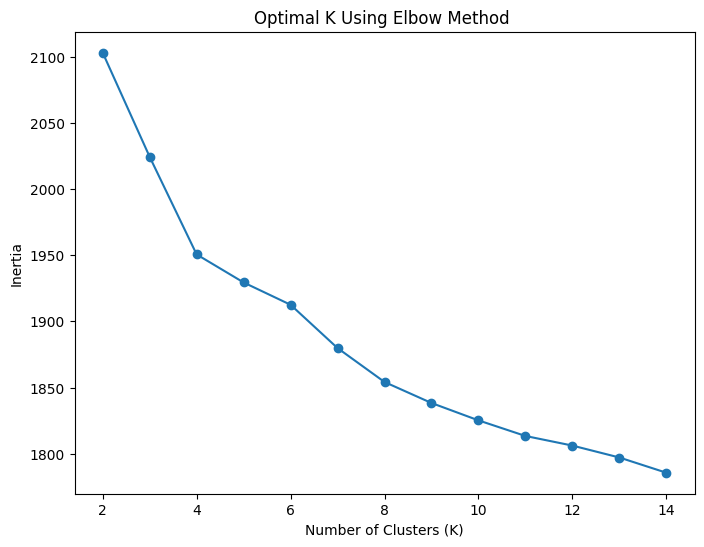

In [25]:
inertia = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Optimal K Using Elbow Method ')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [26]:
optimal_k = 4 # based on elbow method above
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
music_df['cluster_with_kmeans'] = kmeans.fit_predict(embeddings)
print(music_df.head())

                                               Lyric  \
0  Cryptic psalms Amidst the howling winds A scor...   
1  Im sleeping tonight with all the wolves Were d...   
2  Wings of the darkest descent Fall from the rea...   
3  [Verse 1] Norrid Radd was my real name Had a j...   
4  Deep in the dungeons of doom and despair Sneak...   

                                       Lyric_cleaned  \
0  cryptic psalms amidst howling winds scorching ...   
1  im sleeping tonight wolves dreaming life thats...   
2  wings darkest descent fall realm dark blackest...   
3  verse norrid radd real name job hated every da...   
4  deep dungeons doom despair sneak place dark ek...   

                                        Lyric_tokens  \
0  [cryptic, psalms, amidst, howling, winds, scor...   
1  [im, sleeping, tonight, wolves, dreaming, life...   
2  [wings, darkest, descent, fall, realm, dark, b...   
3  [verse, norrid, radd, real, name, job, hated, ...   
4  [deep, dungeons, doom, despair, sneak, plac

### K-Means Silhouette Score

In [9]:
score = silhouette_score(embeddings, music_df['cluster_with_kmeans'])
print(f"K-Means Silhouette Score: {score}")

K-Means Silhouette Score: 0.07143732160329819


## 2. DBScan

It's a density-based algorithm.

Density = number of points within a specified radius r (EPS)

Core point = it has more than a specified number of points (MinPts) within it's EPS

Border point = less than Minpts within it's EPS but it's in the neighborhood of
a core point

Noise point = any point that is not a core or border point

- **Advantages:** Works well for clusters of arbitrary shape and handles noise well.

- **Disadvantages:** Struggles with varying densities.

Determining EPS using Elbow method
- points in a cluster, their kth nearest neighbors are about the same distance
- noise points have their kth nearest neighbor at further distance
- plot sorted distance of every point to it's kth nearest neighbors and find the elbow for the optimal EPS.

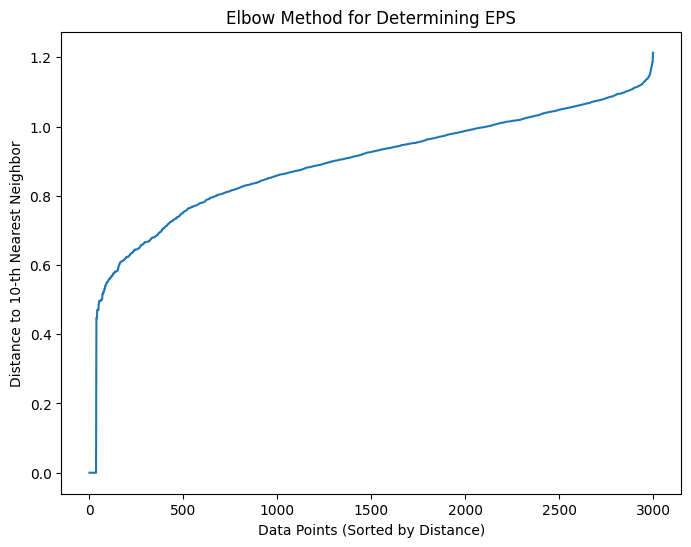

In [27]:
k = 10 # experiment and find the optimal k
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(embeddings)
distances, indices = neighbors.kneighbors(embeddings)
sorted_distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(8, 6))
plt.plot(sorted_distances)
plt.title('Elbow Method for Determining EPS')
plt.xlabel('Data Points (Sorted by Distance)')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
plt.show()



here we use cosine similarity as our distance measure.

In [28]:
EPS = 0.6
MinPts = 5 # experiment and find the best silhouette score
distances = cosine_distances(embeddings)

dbscan = DBSCAN(metric='precomputed', eps=EPS, min_samples=MinPts)
music_df['cluster_with_dbscan'] = dbscan.fit_predict(distances)
print(music_df.head())

                                               Lyric  \
0  Cryptic psalms Amidst the howling winds A scor...   
1  Im sleeping tonight with all the wolves Were d...   
2  Wings of the darkest descent Fall from the rea...   
3  [Verse 1] Norrid Radd was my real name Had a j...   
4  Deep in the dungeons of doom and despair Sneak...   

                                       Lyric_cleaned  \
0  cryptic psalms amidst howling winds scorching ...   
1  im sleeping tonight wolves dreaming life thats...   
2  wings darkest descent fall realm dark blackest...   
3  verse norrid radd real name job hated every da...   
4  deep dungeons doom despair sneak place dark ek...   

                                        Lyric_tokens  \
0  [cryptic, psalms, amidst, howling, winds, scor...   
1  [im, sleeping, tonight, wolves, dreaming, life...   
2  [wings, darkest, descent, fall, realm, dark, b...   
3  [verse, norrid, radd, real, name, job, hated, ...   
4  [deep, dungeons, doom, despair, sneak, plac

### DBScan Silhouette Score

In [12]:
score = silhouette_score(embeddings, music_df['cluster_with_dbscan'])
print(f"DBSCAN Silhouette Score: {score}")

DBSCAN Silhouette Score: 0.06976322084665298


## 3. Agglomerative Hierarchical Clustering

Starts with each data point as its own cluster and merges the closest clusters until only one cluster remains or a stopping condition is met (threshold).

- **Advantages:** Predefined number of clusters is not needed.

- **Disadvantages:** Slow and computationally expensive for large datasets.

linkage criteria
- Closest Pair (Single Linkage): The distance between two clusters is defined as the minimum distance between any single point in one cluster and any single point in the other cluster.

- Furthest Pair (Complete Linkage): The distance between two clusters is defined as the maximum distance between any single point in one cluster and any single point in the other cluster.

- Average (Average Linkage): The distance between two clusters is defined as the average distance between all pairs of points, where each pair consists of one point from each cluster.

- Ward linkage: It seeks to minimize the increase in total within-cluster variance when merging two clusters.

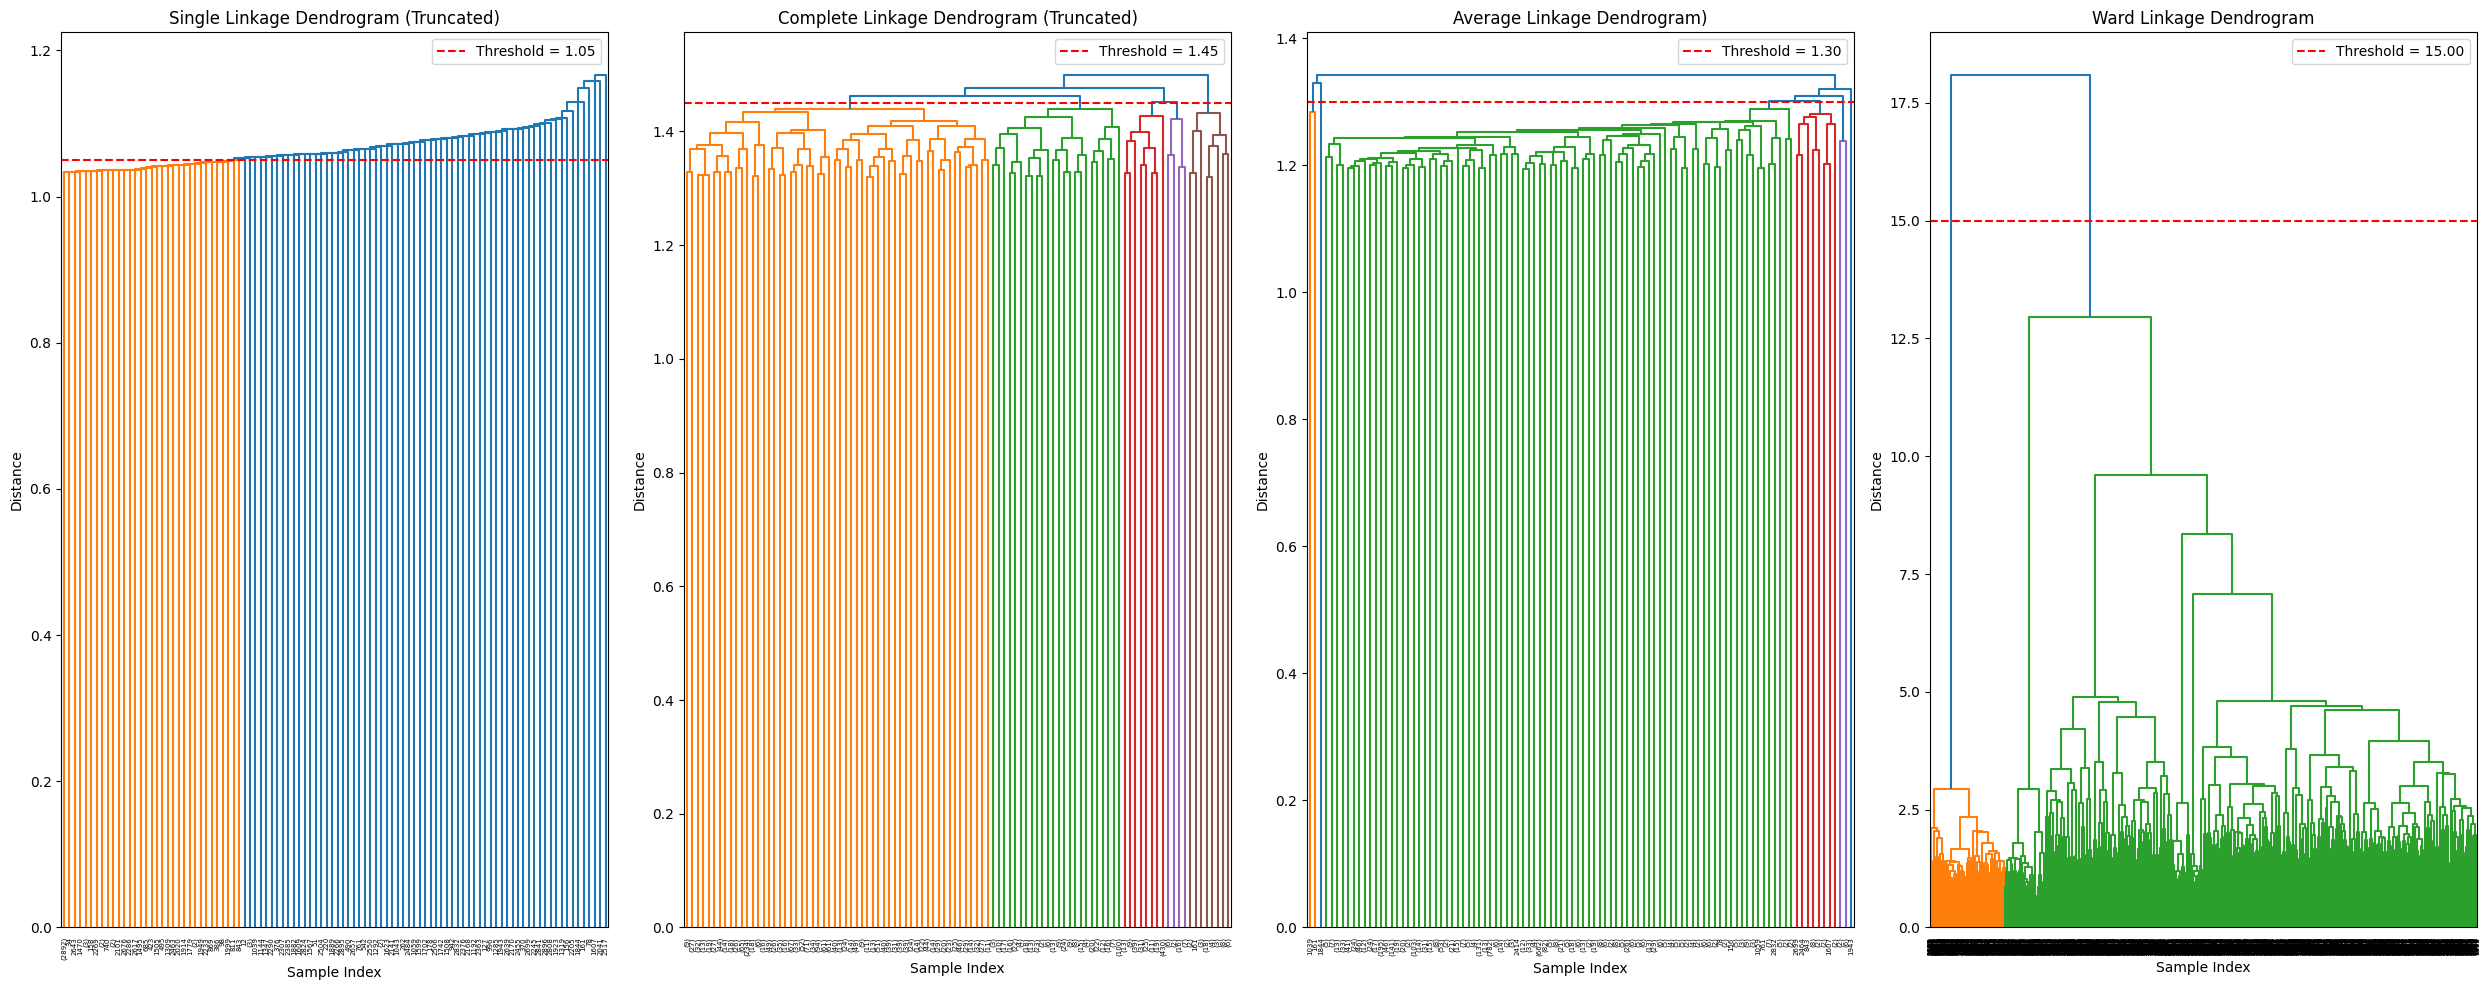

In [14]:
# Increase recursion depth (needed for complete linkage)
sys.setrecursionlimit(2000)

linked_single = linkage(embeddings, 'single')
linked_complete = linkage(embeddings, 'complete')
linked_average = linkage(embeddings, 'average')
linked_ward = linkage(embeddings, 'ward')

plt.figure(figsize=(25, 10))

# Truncate to show only the last 'p' merged clusters (e.g., p=30)
p_truncate = 100

# according to PCA in below cells, we want about 2-4 clusters.
threshold_single = 1.05
threshold_complete = 1.45
threshold_average = 1.3
threshold_ward = 15


plt.subplot(1, 4, 1)
dendrogram(linked_single,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True,
            truncate_mode='lastp',
            p=p_truncate,
            color_threshold=threshold_single)


plt.title('Single Linkage Dendrogram (Truncated)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=threshold_single, color='r', linestyle='--', label=f'Threshold = {threshold_single:.2f}')
plt.legend()


plt.subplot(1, 4, 2)
dendrogram(linked_complete,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True,
            truncate_mode='lastp',
            p=p_truncate,
            color_threshold=threshold_complete)

plt.title('Complete Linkage Dendrogram (Truncated)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=threshold_complete, color='r', linestyle='--', label=f'Threshold = {threshold_complete:.2f}')
plt.legend()


plt.subplot(1, 4, 3)
dendrogram(linked_average,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True,
            truncate_mode='lastp',
            p=p_truncate,
            color_threshold=threshold_average)

plt.title('Average Linkage Dendrogram)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=threshold_average, color='r', linestyle='--', label=f'Threshold = {threshold_average:.2f}')
plt.legend()

plt.subplot(1, 4, 4)
dendrogram(linked_ward,
            orientation='top',
            distance_sort='desce nding',
            show_leaf_counts=True,
            p=p_truncate,
            color_threshold=threshold_ward)


plt.title('Ward Linkage Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=threshold_ward, color='r', linestyle='--', label=f'Threshold = {threshold_ward:.2f}')
plt.legend()


plt.tight_layout()
plt.show()

In [30]:
music_df['cluster_with_hierarchical'] = fcluster(linked_ward, t=15, criterion='distance')

### Hierarchical Clustering Silhouette Score

In [29]:
score = silhouette_score(embeddings, music_df['cluster_with_hierarchical'])
print(f"DBSCAN Silhouette Score: {score}")

DBSCAN Silhouette Score: 0.06274810433387756


### Methods Comparison
Based on the **Silhouette Score**, the order of performance is:  

**K-means >  > DBSCAN > Hierarchical Clustering**.

K-means performed the best, indicating that our dataset is most likely spherical and balanced.

## PCA
**Principal Component Analysis (PCA)** is a dimensionality reduction technique. It works by transforming the original dataset into a new coordinate system where the data is represented using ***fewer dimensions*** while preserving the ***maximum variance***.
1. Normalize the data (zero mean and unit variance)
2. Compute the covariance matrix
3. Eigen Decomposition

 Calculate the eigenvalues and eigenvectors of the covariance matrix.  

  Eigenvectors are special vectors that do not change their direction when a linear transformation is applied to them. The factor by which an eigenvector's magnitude is scaled during the transformation is called its eigenvalue
4. Select Principal Components

 Select the eigenvectors with the largest corresponding eigenvalues.
5. Transform Data

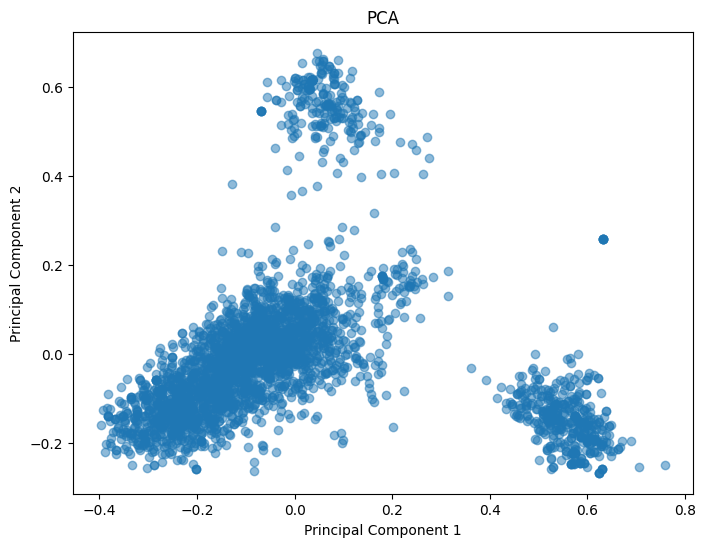

In [31]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], alpha=0.5)
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Evaluation
1. Silhouette Score

    Measures how similar a data point is to its own cluster compared to other clusters. It quantifies how well-separated the clusters are. It ranges from -1 (worst) to 1 (best).
2. Homogeneity

    Measures whether each cluster contains only data points belonging to a single class (assuming you have ground truth class labels). It quantifies how pure the clusters are in terms of the true classes. It ranges from 0 (worst) to 1 (best).

Even with labeled data, there are still reasons why you might perform clustering (unsupervised learning) and then use the ground truth labels for evaluation. Here we don't have the ground truth labels so we must use Silhouette Score.

# Implement different methods with the reduced features after PCA

## K-Means

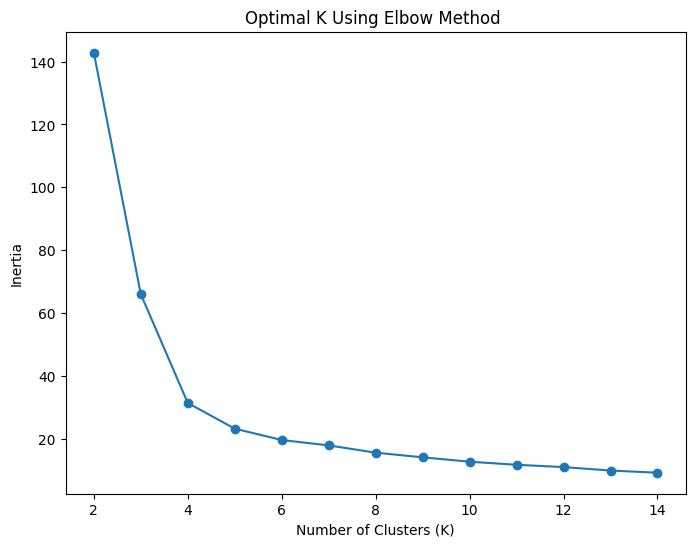

In [32]:
inertia = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Optimal K Using Elbow Method ')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

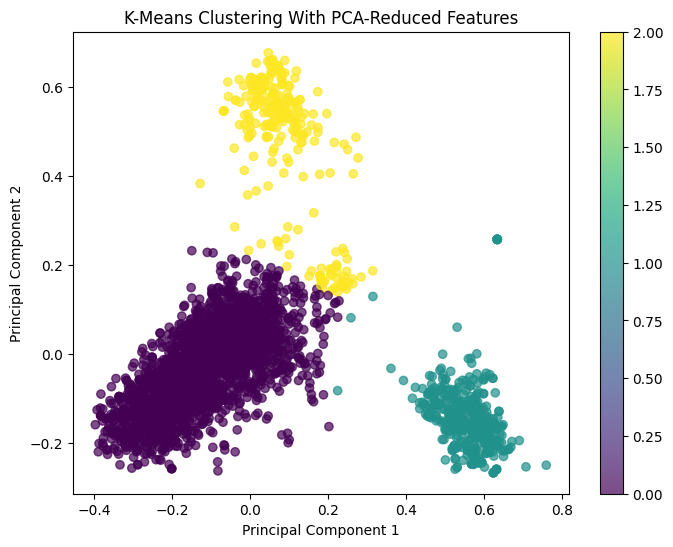

K-Means Silhouette Score With Reduced Features: 0.6794164776802063


In [33]:
optimal_k = 3 # based on elbow method above
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
music_df['cluster_with_kmeans_reduced_features'] = kmeans.fit_predict(reduced_features)


plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_features[:, 0], reduced_features[:, 1],
    c=music_df['cluster_with_kmeans_reduced_features'], cmap='viridis', alpha=0.7
)
plt.title('K-Means Clustering With PCA-Reduced Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

score = silhouette_score(reduced_features, music_df['cluster_with_kmeans_reduced_features'])
print(f"K-Means Silhouette Score With Reduced Features: {score}")

## DBScan

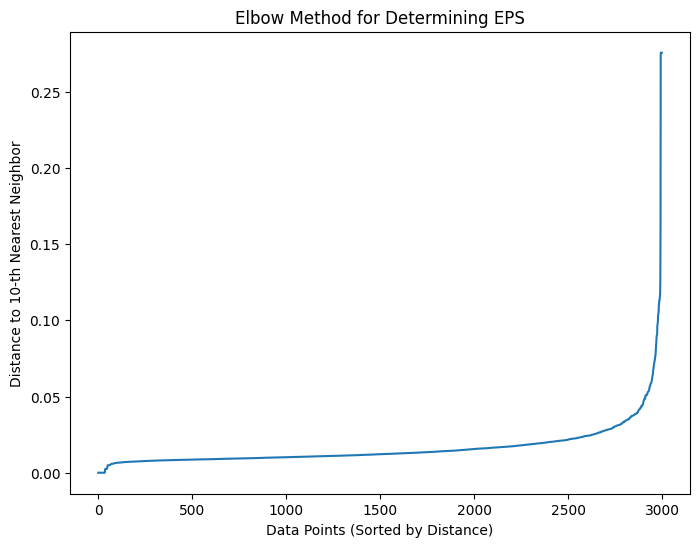

In [20]:
k = 10 # experiment and find the optimal k
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(reduced_features)
distances, indices = neighbors.kneighbors(reduced_features)
sorted_distances = np.sort(distances[:, -1], axis=0)

plt.figure(figsize=(8, 6))
plt.plot(sorted_distances)
plt.title('Elbow Method for Determining EPS')
plt.xlabel('Data Points (Sorted by Distance)')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
plt.show()



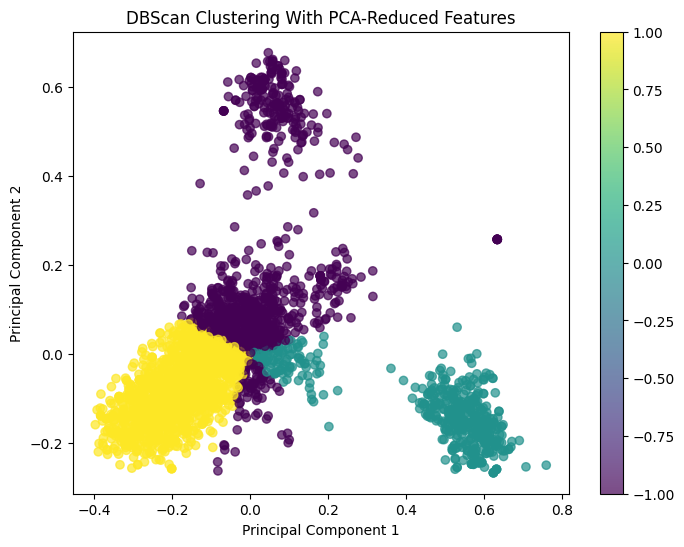

DBSCAN Silhouette Score With Reduced Features: 0.43533211946487427


In [34]:
EPS = 0.05
MinPts = 400 # experiment and find the best silhouette score
distances = cosine_distances(reduced_features)

dbscan = DBSCAN(metric='precomputed', eps=EPS, min_samples=MinPts)
music_df['cluster_with_dbscan_reduced_features'] = dbscan.fit_predict(distances)

plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_features[:, 0], reduced_features[:, 1],
    c=music_df['cluster_with_dbscan_reduced_features'], cmap='viridis', alpha=0.7
)
plt.title('DBScan Clustering With PCA-Reduced Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

score = silhouette_score(reduced_features, music_df['cluster_with_dbscan_reduced_features'])
print(f"DBSCAN Silhouette Score With Reduced Features: {score}")

## Agglomerative Hierarchical Clustering

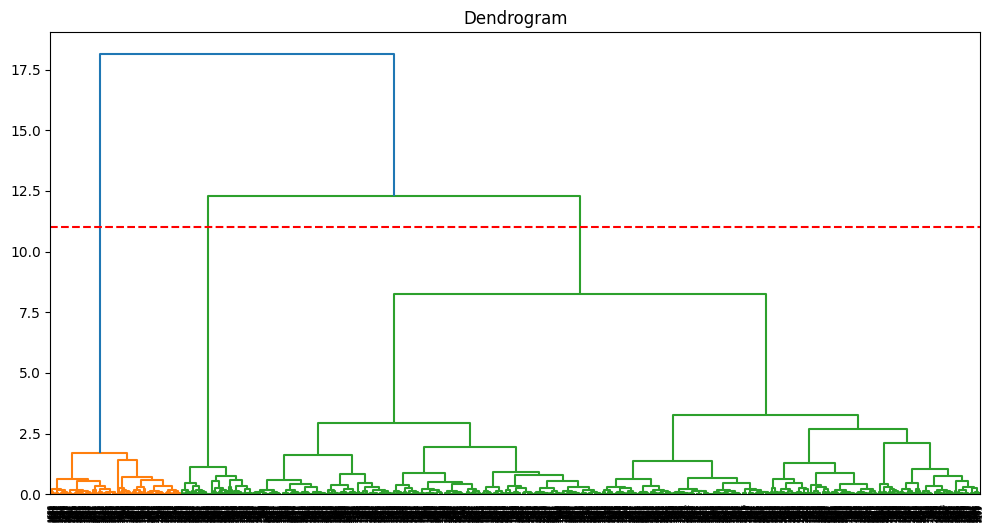

In [22]:
linked_ward = linkage(reduced_features, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked_ward)
plt.axhline(y=11, color='r', linestyle='--')
plt.title('Dendrogram')
plt.show()

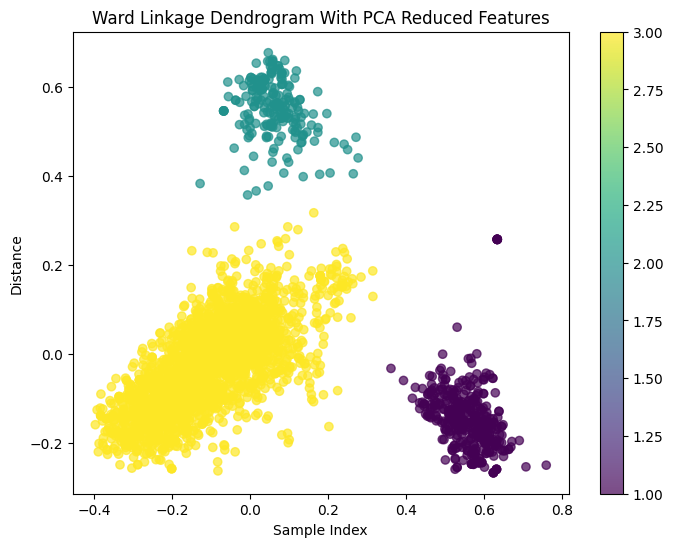

Hierarchical Silhouette Score With Reduced Features: 0.6979561448097229


In [35]:
linked_ward = linkage(reduced_features, method='ward')
music_df['cluster_with_hierarchical_reduced_features'] = fcluster(linked_ward, t=11, criterion='distance')

plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_features[:, 0], reduced_features[:, 1],
    c=music_df['cluster_with_hierarchical_reduced_features'], cmap='viridis', alpha=0.7
)
plt.title('Ward Linkage Dendrogram With PCA Reduced Features')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.colorbar()
plt.show()

score = silhouette_score(reduced_features, music_df['cluster_with_hierarchical_reduced_features'])
print(f"Hierarchical Silhouette Score With Reduced Features: {score}")

### Methods Comparison After PCA Feature Reduction
Based on the **Silhouette Score**, the order of performance is:  

**Hierarchical Clustering > K-means > DBSCAN**

K-means performed the best, indicating that our dataset is most likely spherical and balanced.

In [24]:
music_df.head()

,Lyric,Lyric_cleaned,Lyric_tokens,Lyric_stemmed,Lyric_lemmatized,cluster_with_kmeans,cluster_with_dbscan,cluster_with_hierarchical,cluster_with_kmeans_reduced_features,cluster_with_dbscan_reduced_features,cluster_with_hierarchical_reduced_features
0,Cryptic psalms Amidst the howling winds A scor...,cryptic psalms amidst howling winds scorching ...,"[cryptic, psalms, amidst, howling, winds, scor...","[cryptic, psalm, amidst, howl, wind, scorch, s...","[cryptic, psalm, amidst, howling, wind, scorch...",1,0,1,1,0,1
1,Im sleeping tonight with all the wolves Were d...,im sleeping tonight wolves dreaming life thats...,"[im, sleeping, tonight, wolves, dreaming, life...","[im, sleep, tonight, wolv, dream, life, that, ...","[im, sleeping, tonight, wolf, dreaming, life, ...",3,0,2,0,1,3
2,Wings of the darkest descent Fall from the rea...,wings darkest descent fall realm dark blackest...,"[wings, darkest, descent, fall, realm, dark, b...","[wing, darkest, descent, fall, realm, dark, bl...","[wing, darkest, descent, fall, realm, dark, bl...",2,0,2,0,1,3
3,[Verse 1] Norrid Radd was my real name Had a j...,verse norrid radd real name job hated every da...,"[verse, norrid, radd, real, name, job, hated, ...","[vers, norrid, radd, real, name, job, hate, ev...","[verse, norrid, radd, real, name, job, hated, ...",1,0,1,1,0,1
4,Deep in the dungeons of doom and despair Sneak...,deep dungeons doom despair sneak place dark ek...,"[deep, dungeons, doom, despair, sneak, place, ...","[deep, dungeon, doom, despair, sneak, place, d...","[deep, dungeon, doom, despair, sneak, place, d...",2,0,2,0,-1,3
